In [1]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models

from metric_utils import TMScoreCallback, plot_training_history

print(tf.__version__)
tf.random.set_seed(3004)

2.17.0


In [2]:
#Crear rutas
train_data_path = os.path.join('..', 'data', 'labeled', 'train_labeled.csv')
val_data_path = os.path.join('..', 'data', 'labeled', 'val_labeled.csv')

#Cargar datos
df_train = pd.read_csv(train_data_path)
df_train = df_train.rename(columns={'entropy_log':'log_entropy'})

df_val = pd.read_csv(val_data_path)

df_train = df_train[~((df_train['x_1'] == -1e18) | 
                      (df_train['y_1'] == -1e18) | 
                      (df_train['z_1'] == -1e18))]

# Si deseas aplicar lo mismo a df_val
df_val = df_val[~((df_val['x_1'] == -1e18) | 
                  (df_val['y_1'] == -1e18) | 
                  (df_val['z_1'] == -1e18))]

#Definir columnas
feature_cols = [
    'A', 'C', 'G', 'U',
    'relative_position', 'log_entropy'
]
target_cols = ['x_1', 'y_1', 'z_1']

df_train = df_train.dropna(subset=target_cols).reset_index(drop=True)

#Splits
X_train = df_train[feature_cols].values.astype(np.float32)
y_train = df_train[target_cols].values.astype(np.float32)

X_val = df_val[feature_cols].values.astype(np.float32)
y_val = df_val[target_cols].values.astype(np.float32)

#Meta 
train_meta = df_train[['sequence_id', 'position']].reset_index(drop=True)
val_meta = df_val[['sequence_id', 'position']].reset_index(drop=True)

#Callback
tm_callback = TMScoreCallback(
    X_train, y_train, train_meta,
    X_val, y_val, val_meta
)

In [3]:
df_train.head()

,sequence_id,position,nucleotide,relative_position,A,C,G,U,entropy,log_entropy,x_1,y_1,z_1
0,1SCL_A,0,G,0.000000,False,False,True,False,1.640143,0.970833,13.760,-25.974001,0.102
1,1SCL_A,1,G,0.035714,False,False,True,False,1.901783,1.065325,9.310,-29.638000,2.669
2,1SCL_A,2,G,0.071429,False,False,True,False,1.796112,1.028230,5.529,-27.813000,5.878
3,1SCL_A,3,U,0.107143,False,False,False,True,1.837590,1.042955,2.678,-24.900999,9.793
4,1SCL_A,4,G,0.142857,False,False,True,False,1.840663,1.044038,1.827,-20.136000,11.793


In [4]:
def build_model(input_dim=6):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Dense(256),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Dense(128),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.2),

        layers.Dense(64),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Dense(3)  # Predicción de x, y, z
    ])
    return model

In [5]:
model = build_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [6]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), 
              tm_callback]
)

Epoch 1/100
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22077.8750 - mae: 108.8181
Epoch 1 — TM-score Train: 0.0029, Val: 0.0059
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 22075.4746 - mae: 108.8135 - val_loss: 9182.5703 - val_mae: 85.0425
Epoch 2/100
 993/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16419.5293 - mae: 99.9846
Epoch 2 — TM-score Train: 0.0027, Val: 0.0058
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 16415.1621 - mae: 99.9847 - val_loss: 8685.7412 - val_mae: 82.6516
Epoch 3/100
1002/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16377.4141 - mae: 100.2298
Epoch 3 — TM-score Train: 0.0027, Val: 0.0056
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 16374.8252 - mae: 100.2271 - val_loss: 8761.3506 - val_mae: 82.9547
Epoch 4/100
1016/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16360.4941 - mae: 100.2495
Epoch 4 — TM-score Train: 0.0027, Val: 0.0055
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 16359.6807 - mae: 100.2486 - val_loss: 8707.6865 -

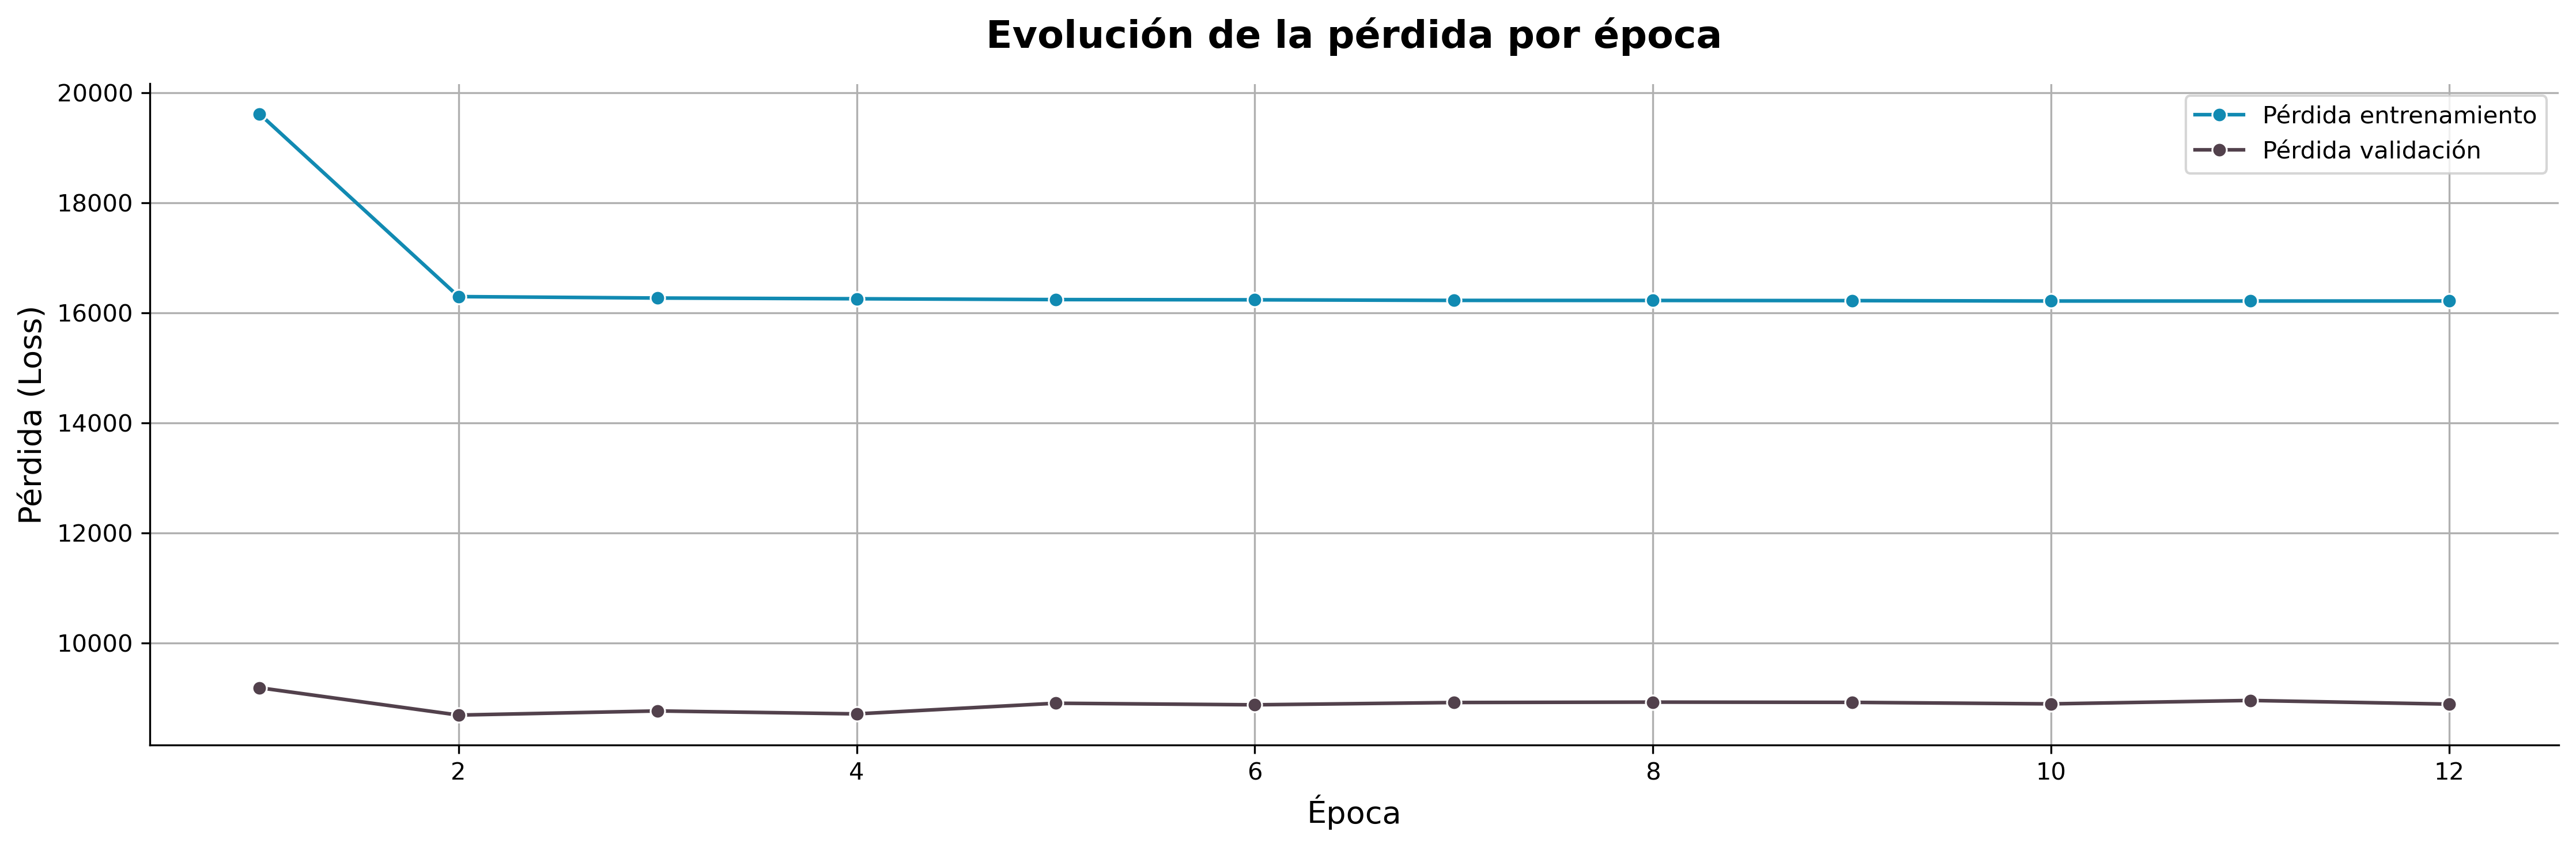

In [7]:
plot_training_history(history, train_tm_score= None, val_tm_score= None)